# PsPNet training en CityScapes images

In [1]:
import os
import re

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color

from IPython.display import Image, display
import PIL
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

import segmentation_models as sm
sm.set_framework('tf.keras')

import albumentations as A

import tensorflow as tf
import keras
print("tensorflow:", tf.__version__)

Segmentation Models: using `keras` framework.
tensorflow: 2.8.0


In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

#set_memory_growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

#seg GPI
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

['/device:CPU:0', '/device:GPU:0']


## Setting up variables and images/segmentation paths

In [3]:
HEIGHT = 384
WIDTH = 384
IMG_SIZE = (WIDTH, HEIGHT)
CLASSES = ['void', 'flat', 'construction', 'object', 'nature', 
               'sky', 'human', 'vehicle']

In [4]:
TRAIN_INPUT_DIR="local_dataset/leftImg8bit/train"
TRAIN_MASK_DIR="local_dataset/gtFine/train"

VAL_INPUT_DIR = "local_dataset/leftImg8bit/val"
VAL_MASK_DIR = "local_dataset/gtFine/val"

TEST_INPUT_DIR = "local_dataset/leftImg8bit/test"
TEST_MASK_DIR = "local_dataset/gtFine/test"

In [5]:
def img_paths(input_dir, mask_dir):
    img_paths=[]
    mask_paths=[]
    for path, subdirs, files in os.walk(input_dir):
        for fname in files:
            if fname.endswith(".png"):
                #image paths
                img_path = os.path.join(path, fname)
                img_paths.append(img_path)
                
                #mask paths
                mask_path = re.sub(input_dir, mask_dir, img_path) #change path
                mask_path = re.sub("leftImg8bit.png", "gtFine_labelIds.png", mask_path) #change mask name
                #path validity check
                if os.path.isfile(mask_path):
                    mask_paths.append(mask_path)
                else:
                    print ("File not exist:", mask_path)
                
    return img_paths, mask_paths

In [6]:
train_img_paths, train_mask_paths= img_paths(TRAIN_INPUT_DIR, TRAIN_MASK_DIR)

val_img_paths,val_mask_paths = img_paths(VAL_INPUT_DIR,VAL_MASK_DIR)

test_img_paths, test_mask_paths = img_paths(TEST_INPUT_DIR,TEST_MASK_DIR)


print("Number of training samples:", len(train_img_paths))

for input_path, target_path in zip(train_img_paths[:1], train_mask_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of validation samples:", len(val_img_paths))
for input_path, target_path in zip(val_img_paths[:1], val_mask_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of test samples:", len(test_img_paths))
for input_path, test_path in zip(test_img_paths[:10], test_mask_paths[:10]):
    print(input_path, "|", test_path)

Number of training samples: 316
local_dataset/leftImg8bit/train\bremen\bremen_000000_000019_leftImg8bit.png | local_dataset/gtFine/train\bremen\bremen_000000_000019_gtFine_labelIds.png
Number of validation samples: 13
local_dataset/leftImg8bit/val\aachen\aachen_000001_000019_leftImg8bit.png | local_dataset/gtFine/val\aachen\aachen_000001_000019_gtFine_labelIds.png
Number of test samples: 1
local_dataset/leftImg8bit/test\munich\munich_000000_000019_leftImg8bit.png | local_dataset/gtFine/test\munich\munich_000000_000019_gtFine_labelIds.png


## Segmentation model building

In [7]:
BACKBONE = 'efficientnetb3' #'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [8]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'softmax'

#create model
model = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 192, 192, 40  160         ['stem_conv[0][0]']              
                                )                                                             

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 96, 96, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 96, 96, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 96, 96, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 96, 96, 192)  0           ['block2c_activation[0][0]',     
          

                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 48, 48, 48)   13824       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 48, 48, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (FixedDropout)    (None, 48, 48, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 48, 48, 48)   0           ['block3b_drop[0][0]',           
          

 ion)                                                                                             
                                                                                                  
 psp_level3_bn (BatchNormalizat  (None, 3, 3, 512)   2048        ['psp_level3_conv[0][0]']        
 ion)                                                                                             
                                                                                                  
 psp_level6_bn (BatchNormalizat  (None, 6, 6, 512)   2048        ['psp_level6_conv[0][0]']        
 ion)                                                                                             
                                                                                                  
 psp_level1_relu (Activation)   (None, 1, 1, 512)    0           ['psp_level1_bn[0][0]']          
                                                                                                  
 psp_level

## Generating the train & validation dataset

###  Building a helper function : Changing label Ids to category Ids 

In [9]:
# Mapping of ignore categories and valid ones (numbered from 1-19)
cat_mapping = { 
            0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 
            7:1, 8:1, 9:1, 10:1, 
            11:2, 12:2, 13:2, 14:2, 15:2, 16:2, 
            17:3, 18:3, 19:3, 20:3, 
            21:4, 22:4, 
            23:5, 
            24:6, 25:6, 26:7, 27:7, 28:7, 29:7, 30:7, 31:7, 32:7, 33:7, -1:7
            }    

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in cat_mapping:
        label_mask[mask == k] = cat_mapping[k]
    return label_mask

In [10]:
def mask_show(mask):
    mask = ((mask - mask.min()) / (mask.max() - mask.min()))
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    plt.show()

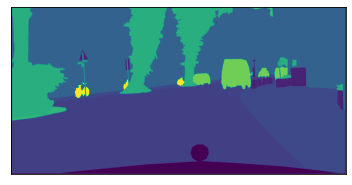

mask_org shape: (1024, 2048, 1)
label ids: [ 1.  3.  4.  7.  8. 11. 17. 20. 21. 22. 23. 26. 33.]


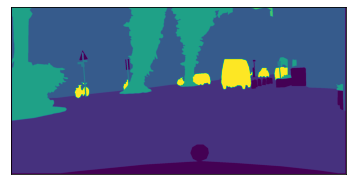


 mask_chg shape: (1024, 2048, 1)
class ids: [0. 1. 2. 3. 4. 5. 7.]


In [11]:
for i in range(1):
    img = load_img(train_mask_paths[i], color_mode="grayscale")
    mask=img_to_array(img)
    mask_show(mask)
    print("mask_org shape:", mask.shape)
    print('label ids:',np.unique(mask))
    
    cat = encode_labels(mask)
    mask_show(cat)
    print("\n mask_chg shape:", cat.shape)
    print('class ids:',np.unique(cat))

### Augmentations

In [14]:
# define heavy augmentations
def get_heavy_augmentation():
    train_transform = [
            #camera issues
            A.HorizontalFlip(p=0.8),
            A.Perspective(p=0.8),
            A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.1, p=0.2, border_mode=0),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.3),
            A.Blur(blur_limit=3, p=0.2),
            A.HueSaturationValue(p=0.2),
    A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
    ]
    return A.Compose(train_transform)


### preprocessing

In [16]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Buiding a data generator class

In [17]:
# classes for data loading and preprocessing
class Dataloader(keras.utils.all_utils.Sequence):
    """Load data from dataset and form batches
    """
    
    CLASSES = ['void', 'flat', 'construction', 'object', 'nature', 
               'sky', 'human', 'vehicle']
    
    
    def __init__(
            self, 
            img_paths, mask_paths,
            img_size,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            batch_size = 1,
            shuffle=False,
            ):
        
        self.ids = img_paths
        self.images_fps = img_paths
        self.masks_fps = mask_paths
        self.img_size = img_size
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.ids) // self.batch_size      
    
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        x=[]
        y=[]
        for j in range(start, stop):
            # read data and resize image
            image = cv2.imread(self.images_fps[j])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.img_size, interpolation = cv2.INTER_AREA)

            # change categories and resize mask
            mask = cv2.imread(self.masks_fps[j], 0)
            mask = encode_labels(mask)
            mask = cv2.resize(mask, self.img_size, interpolation = cv2.INTER_AREA)

            # extract certain classes from mask (e.g. cars)
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
            # add background if mask is not binary
            if mask.shape[-1] != 1:
                background = 1 - mask.sum(axis=-1, keepdims=True)
                mask = np.concatenate((mask, background), axis=-1)

            # apply augmentations
            if self.augmentation:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']

            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
        
            x.append(image)
            y.append(mask)
        
        #  add one more batch dimension to the images/mask arrays.
        batch_x = np.array([np.stack(samples, axis=0) for samples in x])
        batch_y = np.array([np.stack(samples, axis=0) for samples in y])      
        
        return batch_x, batch_y

## Data generation

In [21]:
# Dataset for train images with augmentation

train_dataloader = Dataloader(
    train_img_paths, 
    train_mask_paths,
    img_size = IMG_SIZE,
    classes=CLASSES, 
    augmentation=get_heavy_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=BATCH_SIZE, shuffle=True
)

# Dataset for validation images
valid_dataloader = Dataloader(
    val_img_paths, 
    val_mask_paths,
    img_size=IMG_SIZE,
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=1, shuffle=False
)

# check shapes for errors
assert train_heavyaug_dataloader[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
assert train_heavyaug_dataloader[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, n_classes)

## Models training

In [22]:
# define optomizer
LR= 0.0001
optim = tf.keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [23]:
def history_plot(history):# Plot training & validation iou_score values
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Best val_iou_score: '+ str(max(history.history['val_iou_score'])))
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['f1-score'])
    plt.plot(history.history['val_f1-score'])
    plt.title('Best val_f1-score: ' + str(max(history.history['val_f1-score'])))
    plt.ylabel('f1-score(dice coeff)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

 ## Training

In [41]:
keras.backend.clear_session()

# jaccard coeff loss
total_loss = sm.losses.categorical_focal_dice_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [32]:
%%time

EPOCHS = 15

# train model
history= model.fit(
    train_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 78s 466ms/step - loss: 0.6069 - iou_score: 0.4526 - f1-score: 0.5420 - val_loss: 0.5559 - val_iou_score: 0.5028 - val_f1-score: 0.5920 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 90s 570ms/step - loss: 0.5281 - iou_score: 0.5249 - f1-score: 0.6220 - val_loss: 0.5243 - val_iou_score: 0.5327 - val_f1-score: 0.6191 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 90s 569ms/step - loss: 0.5133 - iou_score: 0.5387 - f1-score: 0.6360 - val_loss: 0.5257 - val_iou_score: 0.5296 - val_f1-score: 0.6159 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 92s 579ms/step - loss: 0.4973 - iou_score: 0.5540 - f1-score: 0.6507 - val_loss: 0.5075 - val_iou_score: 0.5471 - val_f1-score: 0.6349 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 90s 567ms/step - loss: 0.4891 - iou_score: 0.5615 - f1-score: 0.6573 - val_loss: 0.5171 - val_iou_score: 0.5366 - val_f1-s

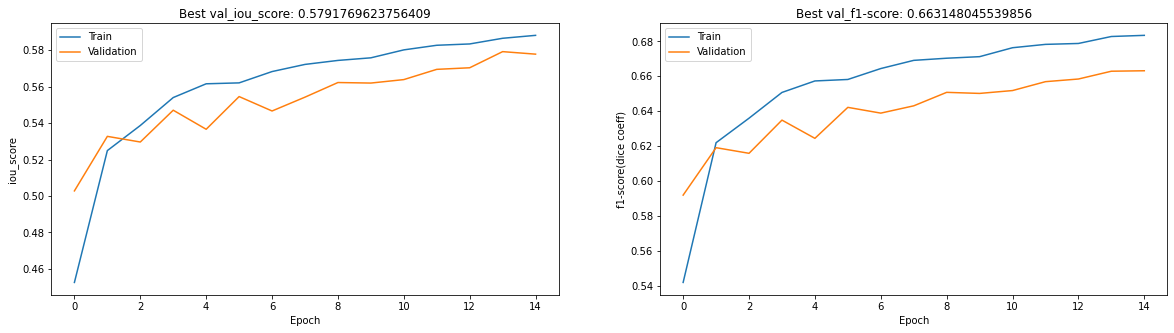

In [35]:
history_plot(history)